### Sources 

https://baseballsavant.mlb.com/leaderboard

https://www.retrosheet.org/downloads/othercsvs.html

https://github.com/chadwickbureau/register/tree/master

In [76]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import re
import glob 

In [63]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [ ]:
# Read files 
pitchers = pd.read_csv("datasets/pitchers.csv")
batters = pd.read_csv("datasets/batters.csv")
plays = pd.concat(map(pd.read_csv, glob.glob("datasets/retrosheet/*plays.csv")), ignore_index=True) 

dtype_spec = {
    8: str, 
    9: str,  
    10: str 
}

register = pd.concat(
    map(lambda f: pd.read_csv(f, dtype=dtype_spec), 
        glob.glob("datasets/chadwick_bureau_register/people-*.csv")),
    ignore_index=True
)


In [38]:
# Extract ids for matching 
mlb_ids = np.unique(np.concatenate((pitchers["player_id"], batters["player_id"])))
print(f"Number of unique MLB ids: {len(mlb_ids)}")

retro_ids = np.unique(np.concatenate((plays["batter"], plays["pitcher"])).astype(str))
print(f"Number of unique retrosheet ids: {len(retro_ids)}")

player_id_map = register[(register['key_mlbam'].isin(mlb_ids) | register['key_retro'].isin(retro_ids))][['key_mlbam', 'key_retro']]

Number of unique MLB ids: 3651
Number of unique retrosheet ids: 3776


In [39]:
pitchers = pd.merge(pitchers, player_id_map, left_on='player_id', right_on='key_mlbam', how='left')
batters = pd.merge(batters, player_id_map, left_on='player_id', right_on='key_mlbam', how='left')

In [ ]:
# Replace any NA for a pitch type with 0 
pitchers.loc[:, pitchers.columns.str.endswith("_formatted")] = pitchers.loc[:, pitchers.columns.str.endswith("_formatted")].fillna(0)
# Rename column to be pitch type percentage 
pitchers = pitchers.rename(columns=lambda col: col[2:-10] + "_pct" if col.endswith("_formatted") and col.startswith("n_") else col)


Cleaning play by play data

In [50]:
# Ensure that there are no duplicate rows 
plays = plays.drop_duplicates()

# Only want to include regular season games 
plays = plays[plays["gametype"] == "regular"]

In [ ]:
# Extract the event based on retrosheet's event text 
def simplify_event(input_str):
    # Define the regular expressions for each case
    patterns = [
        (r'^[0-9]!?/G', 'ground_out'),
        (r'^[0-9]!?/L', 'line_out'),
        (r'^[0-9]!?/P|[0-9]/IF', 'pop_up'),
        (r'^[0-9]!?/F', 'fly_out'),
        (r'^[0-9]!?/BG', 'bunt_ground_out'),
        (r'^[0-9]!?/BP', 'bunt_pop_up'),
        (r'^[0-9]!?/BL', 'bunt_line_drive'), 
        (r'^[0-9]!?/SH', 'sacrifice_bunt'), 
        (r'^[0-9]!?/?/SF', 'sacrifice_fly'), 
        (r'^[0-9]!?[0-9]', 'ground_out'),
        (r'^[0-9]\([^)]*\)|^[0-9][0-9]\([^)]*\)', 'grounded_double_play'),
        (r'^[0-9]\([B]\)[0-9]\([^)]*\)', 'lined_double_play'),
        (r'^[0-9]/BINT', 'batter_interference'), 
        (r'^[C]/E[1-3]', 'interference'),
        (r'^S[0-9]|^S/|S.', 'single'),
        (r'^D[0-9]|^D/', 'double'),
        (r'^T[0-9]|^T/', 'triple'),
        (r'^DGR', 'ground_rule_double'),
        (r'^E[0-9]|^[0-9]E[0-9]', 'error'),
        (r'^FC', 'fielders_choice'),
        (r'^FLE[0-9]', 'error_foul_fly_ball'),
        (r'^HP', 'hit_by_pitch'),
        (r'^H[0-9]|^HR[0-9]', 'inside_park_home_run'),
        (r'^H|^HR', 'home_run'),
        (r'^K', 'strikeout'),
        (r'^NP', 'no_play'),
        (r'^I|^IW', 'intentional_walk'),
        (r'^W', 'walk'),
        (r'^BK', 'balk'),
        (r'^CS[2-3H]', 'caught_stealing'),
        (r'^DI', 'defensive_indifference'),
        (r'^OA', 'base_runner_advance'),
        (r'^PB', 'passed_ball'),
        (r'^WP', 'wild_pitch'),
        (r'^PO', 'picked_off'),
        (r'^SB[2-3H]', 'stolen_base'), 
        (r'^[0-9]', 'out'), 
    ]
    
    # Iterate through the patterns and return the matched outcome
    for pattern, outcome in patterns:
        if re.match(pattern, input_str):
            return outcome
    
    # If no match, return Nones
    return None

In [52]:
plays.loc[:, "simple_event"] = plays["event"].astype(str).apply(simplify_event)

In [53]:
# Focusing on result of the pitcher vs hitter matchup which happens where there is a plate appearance
# The other events focus on the runners
plate_app = plays[plays["pa"] == 1]

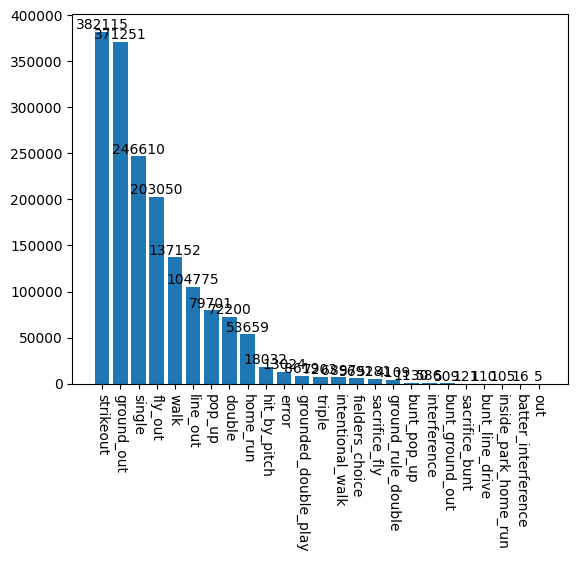

In [54]:
keys, counts = np.unique(plate_app["simple_event"].astype(str), return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
keys = keys[sorted_indices]
counts = counts[sorted_indices]
fig, ax = plt.subplots()
bars = ax.bar(keys, counts)
ax.bar_label(bars)
plt.xticks(rotation=-90)
plt.show()

In [55]:
# From the event want to create a more general outcome variable for prediction 
def determine_outcome(event, hittype): 
    if "interference" in event: 
        return "interference"
    elif "bunt" in event: 
        return "bunt"
    elif "walk" in event: 
        return "walk"
    elif "hit_by_pitch" in event: 
        return "hitbypitch"
    elif event in ["fielders_choice", "ground_out", "grounded_double_play"]: 
        return "groundball"
    elif event in ["fly_out", "sacrifice_fly", "home_run", "ground_rule_double", "inside_park_home_run"]: 
        return "flyball"
    elif event == "line_out": 
        return "linedrive"
    elif event == "pop_up": 
        return "popup"
    elif event == "strikeout": 
        return "strikeout"
    elif event == "home_run": 
        return "flyball"
    elif event in ["single", "double", "triple", "error"]: 
        if hittype in ["BG", "BL", "BP"]: 
            return "bunt"
        elif hittype == "F": 
            return "flyball"
        elif hittype == "G": 
            return "groundball"
        elif hittype == "L": 
            return "linedrive"
        elif hittype == "P": 
            return "popup"
        else: 
            return None
    else: 
        return None

In [56]:
plate_app.loc[:, "outcome"] = plate_app.apply(lambda row: determine_outcome(row["simple_event"], row["hittype"]), axis=1)

C:\Users\sgdea\AppData\Local\Temp\ipykernel_26072\2631515177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plate_app.loc[:, "outcome"] = plate_app.apply(lambda row: determine_outcome(row["simple_event"], row["hittype"]), axis=1)


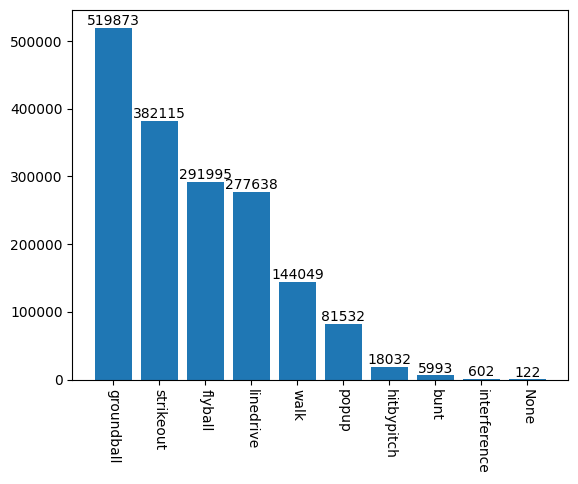

In [57]:
keys, counts = np.unique(plate_app["outcome"].astype(str), return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
keys = keys[sorted_indices]
counts = counts[sorted_indices]
fig, ax = plt.subplots()
bars = ax.bar(keys, counts)
ax.bar_label(bars)
plt.xticks(rotation=-90)
plt.show()

In [81]:
plate_app_clean = plate_app[
    [
        "gid",
        "outcome", 
        "inning",
        "top_bot", 
        "ballpark",
        "batter",
        "pitcher",
        "lp",
        "nump",
        "outs_pre",
        "br1_pre",
        "br2_pre",
        "br3_pre",
        "pn",
        "date",
    ]
]

# Convert runner column to 0 and 1
runner_cols = ["br1_pre", "br2_pre", "br3_pre"]
plate_app_clean.loc[:, runner_cols] = np.where(plate_app_clean[runner_cols].isna(), 0, 1)

# Convert date column to datetime
plate_app_clean.loc[:, "date"] = pd.to_datetime(plate_app_clean["date"].astype(str), format='%Y%m%d')

# Add column for appearance number in game
plate_app_clean["num_times_faced_in_game"] = plate_app_clean.groupby(['gid', 'batter', 'pitcher']).cumcount() + 1

# Drop any events with a missing outcome 
plate_app_clean.dropna(subset=["outcome"], inplace=True)

# Drop any events that were an unclassified error or interference 
plate_app_clean = plate_app_clean[~plate_app_clean["outcome"].isin(["interference", "error"])]

# Create a column for an plate appearance id (pa_id)
plate_app_clean["pa_id"] = plate_app_clean["gid"].astype(str) + "_" + plate_app_clean["pn"].astype(str)

# Remove the gid and pn columns now that pa_id exists
plate_app_clean.drop(['gid', 'pn'], axis=1, inplace=True)

plate_app_clean

,outcome,inning,top_bot,ballpark,batter,pitcher,lp,nump,outs_pre,br1_pre,br2_pre,br3_pre,date,num_times_faced_in_game,pa_id
0,groundball,1,0,ANA01,escoa003,santh001,1.0,6.0,0,0,0,0,2015-04-10,1,ANA201504100_1
1,popup,1,0,ANA01,mousm001,santh001,2.0,1.0,1,0,0,0,2015-04-10,1,ANA201504100_2
2,linedrive,1,0,ANA01,cainl001,santh001,3.0,2.0,2,0,0,0,2015-04-10,1,ANA201504100_3
3,groundball,1,0,ANA01,hosme001,santh001,4.0,6.0,2,0,1,0,2015-04-10,1,ANA201504100_4
4,linedrive,1,0,ANA01,morak001,santh001,5.0,5.0,2,1,0,0,2015-04-10,1,ANA201504100_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808326,walk,9,1,WAS11,younj004,ruizj001,8.0,6.0,0,1,0,0,2024-09-29,1,WAS202409290_108
1808327,groundball,9,1,WAS11,baked003,ruizj001,9.0,4.0,0,1,1,0,2024-09-29,1,WAS202409290_110
1808328,strikeout,9,1,WAS11,garcl006,ruizj001,1.0,3.0,0,1,1,1,2024-09-29,1,WAS202409290_111
1808329,strikeout,9,1,WAS11,woodj004,ruizj001,2.0,5.0,1,1,1,1,2024-09-29,1,WAS202409290_112


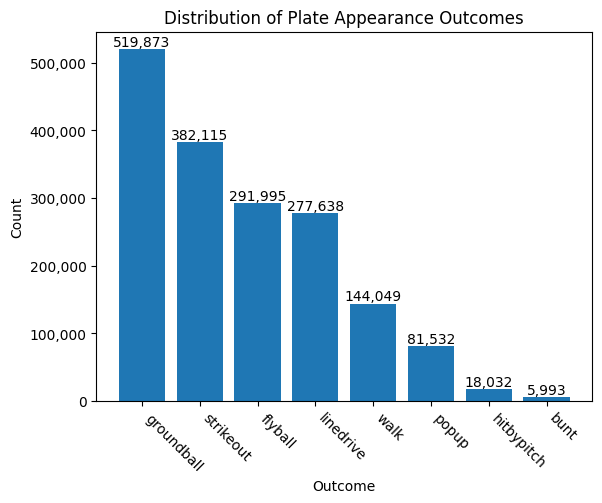

In [82]:
keys, counts = np.unique(plate_app_clean["outcome"].astype(str), return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
keys = keys[sorted_indices]
counts = counts[sorted_indices]

fig, ax = plt.subplots()
bars = ax.bar(keys, counts)

# Format labels with commas
ax.bar_label(bars, labels=[f"{c:,}" for c in counts])

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=-45, ha='left')
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title("Distribution of Plate Appearance Outcomes")
plt.show()